Setting up PySpark in Google Colab: Installing Pyspark and loading the environment

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
!ls

sample_data  spark-3.1.1-bin-hadoop3.2	spark-3.1.1-bin-hadoop3.2.tgz


In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
# spark

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import warnings
def ignore_warn(*args, **kwagrs):
    pass
warnings.warn = ignore_warn

### Mounting the Drive

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Reading DataSet

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('gdrive/My Drive/bank1.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



### Lets have a view on the Dataset

In [8]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


## Lets see if the target is balanced or not
The dataset is not balanced

In [9]:
df.groupby('y').count().toPandas()

,y,count
0,no,36548
1,yes,4640


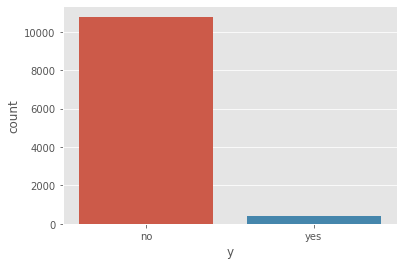

In [10]:
sns.countplot('y', data=pd.DataFrame(df.take(11162),columns = df.columns))
plt.show()

### Lets do some analysis of Numeric features

In [11]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646494,0,4918
campaign,41188,2.567592502670681,2.7700135429023245,1,56
pdays,41188,962.4754540157328,186.9109073447411,0,999
previous,41188,0.17296299893172767,0.4949010798392903,0,7


## Pair Plot
-There are no obvious highly correlated variable pairs <br>
-Let's remove day and month, but keep the rest of the variables <br>
-14 input/predictor variables, 1 response/target variable


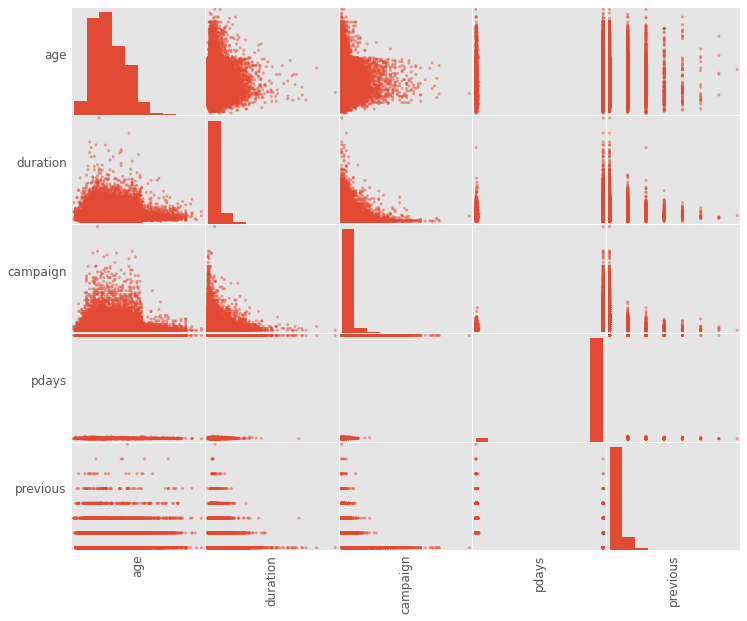

In [12]:
numeric_data = df.select(numeric_features).toPandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(12, 10));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())



# Visualization

## We can see the Age of the people is normally distributed but slightly positively skewed 

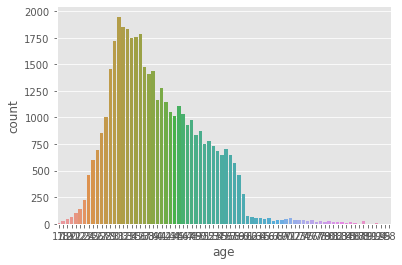

In [13]:
sns.countplot('age', data=numeric_data)

### Most of the People are from Mananagement, BlueCollar and Technicians

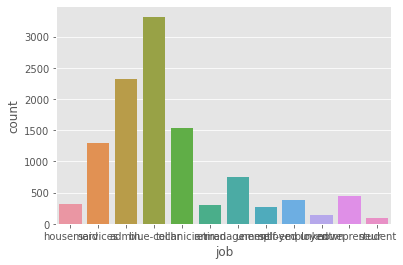

In [14]:
sns.countplot('job', data=pd.DataFrame(df.take(11162),columns = df.columns))

### Count of Married people are more

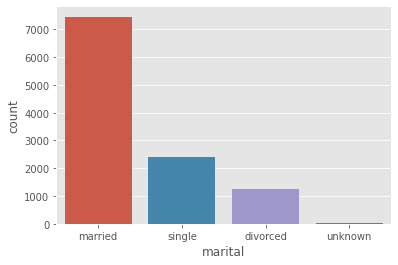

In [15]:
sns.countplot('marital', data=pd.DataFrame(df.take(11162),columns = df.columns))

### Most of the actions were taken during May

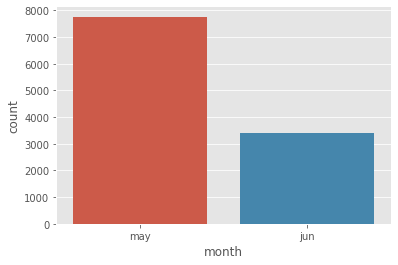

In [16]:
sns.countplot('month', data=pd.DataFrame(df.take(11162),columns = df.columns))

### Eliminating Unneccary features

In [17]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



### Upsampling the imbalanced Data

In [18]:
from pyspark.sql.functions import col, explode, array, lit

major_df = df.filter(col("y") == "no")
minor_df = df.filter(col("y") == "yes")
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()



ratio: 7
+---+-----------+--------+-------------------+-------+-------+----+---------+--------+--------+-----+--------+-----------+---+
|age|        job| marital|          education|default|housing|loan|  contact|duration|campaign|pdays|previous|   poutcome|  y|
+---+-----------+--------+-------------------+-------+-------+----+---------+--------+--------+-----+--------+-----------+---+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|     261|       1|  999|       0|nonexistent| no|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|     149|       1|  999|       0|nonexistent| no|
| 37|   services| married|        high.school|     no|    yes|  no|telephone|     226|       1|  999|       0|nonexistent| no|
| 40|     admin.| married|           basic.6y|     no|     no|  no|telephone|     151|       1|  999|       0|nonexistent| no|
| 56|   services| married|        high.school|     no|     no| yes|telephone|     307|       1|  999| 

In [19]:
combined_df.groupby('y').count().toPandas()

,y,count
0,no,36548
1,yes,32480


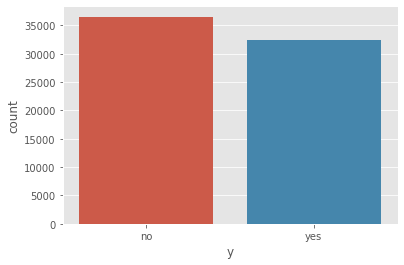

In [23]:
sns.countplot('y', data=pd.DataFrame(combined_df.take(69028),columns = combined_df.columns))
plt.show()

In [24]:
df = combined_df


# Prep Data for Machine Learning: creating a "stages" object to pass into a PySpark ML Pipeline that achieves 3 unique steps:

1. Category Indexing
2. One-Hot Encoding
3. VectorAssembler - a feature transformer that merges multiple columns into a vector column.





###### 1.indexes each categorical column using the StringIndexer, <br> 2.then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. <br> 3.We use the StringIndexer again to encode our labels to label indices. <br> 4.Next, we use the VectorAssembler to combine all the feature columns into a single vector column.



#### # 1. Category Indexing 
#### # 2. One-Hot Encoding

In [30]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []


for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]

### 3. VectorAssembler

In [31]:
numericCols = ['age', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]



## Binary Classification Labels:

    1 = Yes, client has subscribed to a term deposit
    0 = No, client did not subscribe to a term deposit


In [32]:
stages

[StringIndexer_625b949ad6a1,
 OneHotEncoder_b4c5021889bc,
 StringIndexer_522c6d10849b,
 OneHotEncoder_236215a3523f,
 StringIndexer_0f875001bb42,
 OneHotEncoder_521b96925dec,
 StringIndexer_f964eac9fe95,
 OneHotEncoder_099e9c829595,
 StringIndexer_5157bb710996,
 OneHotEncoder_524492454218,
 StringIndexer_45a35b45cfe8,
 OneHotEncoder_d7c09455ad4e,
 StringIndexer_571cae86a14d,
 OneHotEncoder_cf8cd92f57a4,
 StringIndexer_06fe33efa9e2,
 OneHotEncoder_a355946b8f9b,
 StringIndexer_727cf029c247,
 VectorAssembler_3fbc62d2ffee]

### Create Pipeline

In [33]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [34]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone


#### We now have 'features' & 'label' columns

#### let's train-test-split usng randomSplit

In [35]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 48419
Test Dataset Count: 20609


# Modeling
##Logistic Regression

In [36]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [37]:
lrModel.coefficients

DenseVector([-0.0109, -0.5297, -0.2968, -0.4719, -0.244, 0.8661, 1.0954, -0.1765, -0.4589, 0.3154, -0.1556, -0.2378, 0.0787, -0.3368, 0.1093, -0.2399, -0.4035, 0.015, -0.1775, -0.2247, 0.1177, 0.2427, -0.81, -0.0702, -0.1469, -0.136, -0.2693, 1.0154, -0.7259, -0.6769, 0.0097, 0.0057, -0.1145, -0.0018, 0.1868])

#### Beta Coefficient Graph

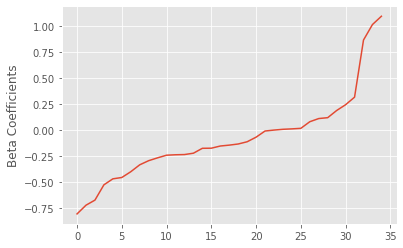

In [38]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

### ROC Curve

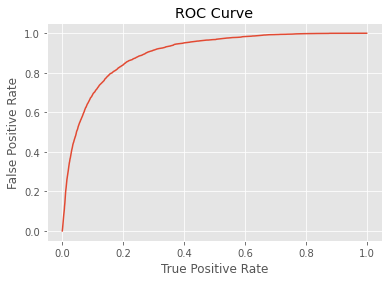

Training set areaUnderROC: 0.8980021727417553


In [39]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Precision Recall Graph

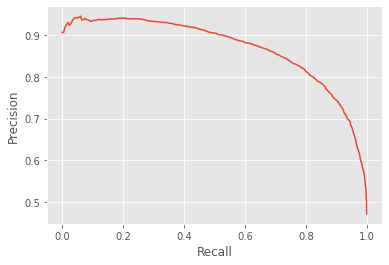

In [40]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### F-Measure by Threshold

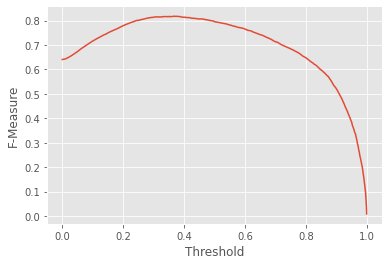

In [41]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

### Make Predictions on Test set

In [42]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|  0.0|[0.92346033899441...|       0.0|[0.71574664865592...|
| 28|admin.|  0.0|[1.28619832709096...|       0.0|[0.78350302151931...|
| 28|admin.|  0.0|[-1.1281045744597...|       1.0|[0.24451106457537...|
| 29|admin.|  0.0|[1.45749974749531...|       0.0|[0.81114996979138...|
| 29|admin.|  0.0|[1.62003333790955...|       0.0|[0.83479972746322...|
| 29|admin.|  0.0|[0.97096954323579...|       0.0|[0.72531270613700...|
| 29|admin.|  0.0|[0.56501806624472...|       0.0|[0.63761282706776...|
| 30|admin.|  0.0|[1.03478173246653...|       0.0|[0.73784188362414...|
| 30|admin.|  0.0|[0.85374723785833...|       0.0|[0.70135261986926...|
| 30|admin.|  0.0|[0.58785282390255...|       0.0|[0.64287233228000...|
+---+------+-----+--------------------+----------+--------------

In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8956704143885055



## Tuning Model Parameters with ParaGridBuilder & Cross Validator

In [44]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.896185484608329


##Decision Tree

In [45]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+----------------+----------+--------------------+
|age|   job|label|   rawPrediction|prediction|         probability|
+---+------+-----+----------------+----------+--------------------+
| 24|admin.|  0.0|[17447.0,3110.0]|       0.0|[0.84871333365763...|
| 28|admin.|  0.0|[17447.0,3110.0]|       0.0|[0.84871333365763...|
| 28|admin.|  0.0|[1981.0,10418.0]|       1.0|[0.15977094927010...|
| 29|admin.|  0.0|[17447.0,3110.0]|       0.0|[0.84871333365763...|
| 29|admin.|  0.0|[17447.0,3110.0]|       0.0|[0.84871333365763...|
| 29|admin.|  0.0|[17447.0,3110.0]|       0.0|[0.84871333365763...|
| 29|admin.|  0.0|[17447.0,3110.0]|       0.0|[0.84871333365763...|
| 30|admin.|  0.0|[17447.0,3110.0]|       0.0|[0.84871333365763...|
| 30|admin.|  0.0|[17447.0,3110.0]|       0.0|[0.84871333365763...|
| 30|admin.|  0.0|[17447.0,3110.0]|       0.0|[0.84871333365763...|
+---+------+-----+----------------+----------+--------------------+
only showing top 10 rows



In [46]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6619812675543886


- It is useful because it is easy to interpret
- can handle categorical features
- can handle multiclass classification
- feature scaling not necessary
- can capture non-linearities and feature interactions

##Random Forest Classifier

In [47]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|  0.0|[14.0577651768140...|       0.0|[0.70288825884070...|
| 28|admin.|  0.0|[14.0577651768140...|       0.0|[0.70288825884070...|
| 28|admin.|  0.0|[7.74371476312030...|       1.0|[0.38718573815601...|
| 29|admin.|  0.0|[14.0609994879678...|       0.0|[0.70304997439839...|
| 29|admin.|  0.0|[14.2649040724329...|       0.0|[0.71324520362164...|
| 29|admin.|  0.0|[14.0609994879678...|       0.0|[0.70304997439839...|
| 29|admin.|  0.0|[14.0609994879678...|       0.0|[0.70304997439839...|
| 30|admin.|  0.0|[14.0609994879678...|       0.0|[0.70304997439839...|
| 30|admin.|  0.0|[14.0609994879678...|       0.0|[0.70304997439839...|
| 30|admin.|  0.0|[14.0609994879678...|       0.0|[0.70304997439839...|
+---+------+-----+--------------------+----------+--------------

In [48]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.882868997324552


#### Random Forest Parameter explanations

In [49]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

##Gradient-boosted Tree Classifier

In [50]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|  0.0|[0.32269087229036...|       0.0|[0.65596899603785...|
| 28|admin.|  0.0|[1.20741664212211...|       0.0|[0.91795144449897...|
| 28|admin.|  0.0|[-0.3947236246647...|       1.0|[0.31228736802538...|
| 29|admin.|  0.0|[1.21084335908224...|       0.0|[0.91846614544658...|
| 29|admin.|  0.0|[1.24657224030929...|       0.0|[0.92365982297030...|
| 29|admin.|  0.0|[0.71708598294431...|       0.0|[0.80755052419721...|
| 29|admin.|  0.0|[0.33530684053594...|       0.0|[0.66164055903936...|
| 30|admin.|  0.0|[0.71708598294431...|       0.0|[0.80755052419721...|
| 30|admin.|  0.0|[0.38973159134531...|       0.0|[0.68556440598693...|
| 30|admin.|  0.0|[0.44450220955398...|       0.0|[0.70868467689971...|
+---+------+-----+--------------------+----------+--------------

In [51]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9011980450785398




    -Gradient-boosted Tree achieved the best result at ROC-AUC Score of 0.89,
    -Let's try tuning this model with the ParamGridBuilder and the CrossValidator.
    -we can use explainParams() to print a list of all params and their definitions to understand what params available for tuning.



#### Tuning Gradient Boosted Tree Model with ParamGridBuilder and CrossValidator

In [52]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [53]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9123685521854508


##Conclusion:
As we can see that ROC Score for Boosting Algorithm is slight higher than the other we can observe that it is because it converts weak learner variables to strong ones.
Therefore Gradient Boosting with the Best Params which we have found using Grid Search and validated using CrossValidation is the best model to gain the results accurately.
